In [227]:
import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

## Funciones

Distribuciones para inicializar los pesos. Son generadores que se inicializan con los parámetros de la distribución, devuelven la distribución que debe aceptar como argumento una tupla con la forma `(filas, columnas)`.

In [417]:
def distribución_uniforme(menor=-0.1, mayor=0.1):
    return lambda forma: np.random.uniform(low=menor, high=mayor, size=forma)

Funciones de costo para calcular el error.

In [118]:
def error_cuadrático_medio(objetivo, predicción):
    return np.mean( (objetivo - predicción)**2 ) / 2

Funciones de activación con sus derivadas. Son generadores que se inicializan con los parámetros de la función, devuelven la función y su derivada, ambas deben aceptar como argumento un arreglo de Numpy.

In [414]:
def escalón():
    f = lambda x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
    d = lambda x: 1
    
    return f, d


def identidad():
    f = lambda x: x
    d = lambda x: 1
    
    return f, d


def relu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0, 1])

    return f, d


# leaky ReLU, la derivada para x <= 0 no es nula sino un valor pequeño
def lrelu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0.01, 1])

    return f, d


def logística():
    f = lambda x: 1 / (1 + np.exp(-x))
    d = lambda x: f(x) * (1 - f(x))

    return f, d


def tanh():
    f = np.tanh
    d = lambda x: 1 - f(x)**2
    
    return f, d

## Elementos de la red

Una **capa** se define en base a cierta cantidad de unidades con una función de activación.

En la **propagación** el parámetro `i` representa el valor de entrada a las unidades y el parámetro `o`, el de salida. Cabe notar que a la salida se le agrega el bias de la capa. El bias es _virtual_, no está representado como unidad.

```
    entrada    función activación    salida
                                     | o0 | = 1 (BIAS)
    | i1 |                           | o1 |
    | i2 | --> f(i) ---------------> | o2 |
    | i3 |                           | o3 |
```

Cuando consideramos la **retropropagación** del error, el sentido inverso utiliza los parámetros `ei` y `eo` para los errores que entran a y salen de la capa, respectivamente.

```
    salida     derivada activación   entrada
                                     | ei0 | = 1 (BIAS)
    | eo1 |                          | ei1 |
    | eo2 | <- f'(i) · ei <--------- | ei2 |
    | eo3 |                          | ei3 |
```

In [60]:
class Capa:
    
    def __init__(self, activación, unidades):
        self.función, self.derivada = activación()
        self.unidades = unidades
        self.feeds = []
        self.backs = []
        
        
    def propagar(self):
        Y = self.función(self.i)
        self.o = np.insert(Y, 0, 1., axis=1) # agregar vector columna de bias
        
        for sinapsis in self.feeds: sinapsis.propagar()

            
    def retropropagar(self, eta):
        E = np.delete(self.ei, 0, axis=1) # remover vector columna de bias
        self.eo = E * self.derivada(self.i)
        
        for sinapsis in self.backs: sinapsis.retropropagar(eta)
        
        
    def estado(self):
        return np.delete(self.o, 0, axis=1) # remover vector columna de bias
    
    
    def error(self, E):
        self.ei = np.insert(E, 0, 1., axis=1) # agregar vector columna de bias

Las capas se comunican mediante **sinapsis**. Una sinapsis tiene una capa de _origen_ y una de _destino_, a su vez guarda los pesos de las conexiones entre unidades.

Los elementos de la red están pensados para tratar a las muestas como *vectores filas*. En un arreglo bidimensional de varias muestras, cada fila es una muestra y las columnas del arreglo son los distintos atributos. En la bibliografía se suele observar otro camino: las muestras son *vectores columnas*; quizás sea más sencillo para hacer/interpretar cuentas. En la práctica, encontramos a los vectores filas más a tono con la forma de los conjuntos de datos (pensar en un archivo CSV o en una tabla de una base de datos).

```
    filas    = dim(origen) + 1 (BIAS)
    columnas = dim(destino)
    
    W =  | b00  b01 |  matriz de pesos de una sinapsis que conecta una capa de 3 unidades (origen) con otra de 2 (destino)
         | w10  w11 |  la primera fila corresponde a los pesos del bias
         | w20  w21 |
         | w30  w31 |
         
    Y =  | 1  a1  a2  a3 |  actividad de salida de la capa de origen, 2 muestras con 3 atributos y bias (primera columna)
         | 1  b1  b2  b3 |
         
    Z =  Y · W =  | a'1  a'2 |  la actividad de entrada a la capa de destino entonces se calcula
                  | b'1  b'2 |  como el producto interno entre la salida (Y) y los pesos (W)
```

In [249]:
class Sinapsis:
  
    def __init__(self, origen, destino, inicialización):
        self.origen  = origen
        self.destino = destino
        
        forma  = (origen.unidades + 1, destino.unidades)      
        self.W = inicialización(forma)
        
        
    def propagar(self):
        Y = self.origen.o # actividad de la capa anterior
        self.destino.i = np.dot(Y, self.W)
        
    
    def retropropagar(self, eta):
        E = self.destino.eo # error de la capa posterior        
        self.origen.ei = np.dot(E, self.W.T)
        self.ajustar_pesos(eta)
        
          
    def ajustar_pesos(self, eta):
        Y = self.origen.o # actividad de la capa anterior
        E = self.destino.eo # error de la capa posterior
        
        self.W += eta * np.dot(Y.T, E)

Las siguientes funciones se utilizan durante el entrenamiento.

In [364]:
def lotes(X, y, n):
    if n < 1: n = len(X)
    
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def barajar(X, y):
    e = np.random.get_state()
    X = np.random.permutation(X)
    np.random.set_state(e)
    y = np.random.permutation(y)
    
    return X, y


def graficar(evolución_error):
    plt.plot(evolución_error)
    plt.xlabel('épocas')
    plt.ylabel('error')

In [424]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import binarize

class Red(BaseEstimator):

    def __init__(self, activación=logística, inicialización=distribución_uniforme(), capas_ocultas=(),
                 tamaño_lote=1, factor_aprendizaje=0.01, épocas=1000, tolerancia=1e-4):
        
        self.activación = activación
        self.inicialización = inicialización
        self.capas_ocultas = capas_ocultas
        self.tamaño_lote = tamaño_lote
        self.factor_aprendizaje = factor_aprendizaje
        self.épocas = épocas
        self.tolerancia = tolerancia
        
    
    def _preinicializar(self, n_entradas, n_salidas):
        capas = [('entrada', identidad, n_entradas)]
        
        for i, n_unidades in enumerate(self.capas_ocultas):
            id_capa = 'oculta_%s' % (i + 1)
            capa = (id_capa, self.activación, n_unidades)
            capas.append(capa)
        
        capas.append( ('salida', self.activación, n_salidas) )
        
        conexiones = \
        [(capa_origen[0], capa_destino[0], self.inicialización) for capa_origen, capa_destino in zip(capas, capas[1:])]

        return capas, conexiones
    
    
    def _inicializar(self, capas, conexiones):
        self.capas    = OrderedDict()
        self.sinapsis = OrderedDict()
        
        # instanciación de capas
        for (id, activación, unidades) in capas:
            self.capas[id] = Capa(activación, unidades)        
            
        # instanciación de sinapsis
        for (id_origen, id_destino, inicialización) in conexiones:
            origen   = self.capas[id_origen]
            destino  = self.capas[id_destino]
            
            sinapsis = self.sinapsis[(id_origen, id_destino)] = Sinapsis(origen, destino, inicialización)
            
            origen.feeds.append(sinapsis)
            destino.backs.append(sinapsis)        
    
    
    def fit(self, X, y):
        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        n_entradas = X.shape[1]
        n_salidas  = y.shape[1]
        
        self._inicializar(*self._preinicializar(n_entradas, n_salidas))
        
        self.evolución_error = []
        self.convergencia = False
        
        for época in range(self.épocas):
            _X, _y = barajar(X, y)
            
            y_pred = np.concatenate(
                [self._aprender(lote_X, lote_y, self.factor_aprendizaje) for lote_X, lote_y in lotes(_X, _y, self.tamaño_lote)]
            )
            
            error = error_cuadrático_medio(_y, y_pred)
            self.evolución_error.append(error)
            
            if error <= self.tolerancia:
                self.convergencia = True
                break
        
        return self
       
                 
    def _aprender(self, X, y_obj, eta):
        y_pred = self.predict(X)
        
        self.capas['salida'].error(y_obj - y_pred) 
        
        for _, capa in reversed(self.capas.items()): capa.retropropagar(eta)
        
        return y_pred
        
    
    def predict(self, X):
        self.capas['entrada'].i = X
        
        for _, capa in self.capas.items(): capa.propagar()
        
        return self.capas['salida'].estado()
    
    
    def score(self, X, y):
        return accuracy_score(y, binarize(self.predict(X), threshold=0.5))

## Pruebas

In [349]:
X = np.array([[1, 1],
              [1, 0],
              [0, 1],
              [0, 0]])

y = np.array([[1, 1, 0],
              [0, 1, 1],
              [0, 1, 1],
              [0, 0, 0]])

convergencia False


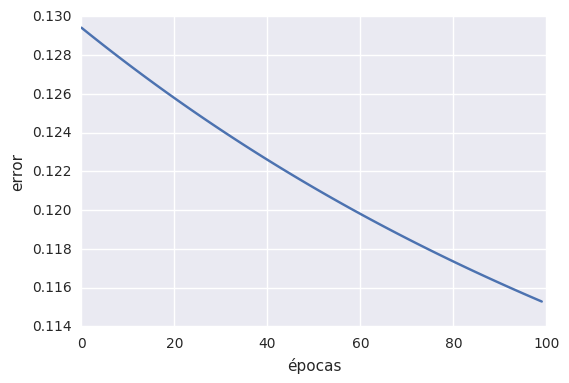

In [350]:
rn = Red().fit(X, y)
print('convergencia', rn.convergencia)
graficar(rn.evolución_error)
#plt.savefig('error.png')

## Experimentos

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import LabelBinarizer
from sklearn.pipeline        import make_pipeline

tp1 = 'tp1_ej1_training.csv'
tp2 = 'tp1_ej2_training.csv'

X_tp1 = np.loadtxt(tp1, dtype='float', delimiter=',', usecols=range(1,10))
y_tp1 = np.loadtxt(tp1, dtype='str',   delimiter=',', usecols=(0,))

X_tp2 = np.loadtxt(tp2, delimiter=',', usecols=(0,1,2,3,4,5))
y_tp2 = np.loadtxt(tp2, delimiter=',', usecols=(6,7))

# transforma las etiquetas 'B' y 'M' a ceros y unos
binarizer = LabelBinarizer()
y_tp1 = binarizer.fit_transform(y_tp1)

# partición del conjunto de datos en conjuntos de entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tp1, y_tp1, test_size=0.3, random_state=42)

In [351]:
# transformación de los datos: se remueve la media y se lleva la varianza a la unidad
# en base a las propiedades del conjunto de entrenamiento
scaler = StandardScaler()

rn = Red(capas_ocultas=[9], tamaño_lote=10, factor_aprendizaje=.35, épocas=3000)

clf = make_pipeline(scaler, rn)
clf.fit(X_train, y_train)

print('efectividad', clf.score(X_test, y_test))
print('error', rn.evolución_error[-1])
print('épocas', len(rn.evolución_error))
print('convergencia', rn.convergencia)
graficar(rn.evolución_error)

### Grid search

In [428]:
from sklearn.model_selection import GridSearchCV

estimador = make_pipeline(StandardScaler(), Red())

grilla = {       
                  'red__activación': [logística, relu],
              'red__inicialización': [distribución_uniforme(menor=-0.1, mayor=0.1),
                                 distribución_uniforme(menor=-1.0, mayor=1.0),
                                 distribución_uniforme(menor= 0.0, mayor=1.0),
                                 distribución_uniforme(menor= 0.5, mayor=0.5)],
               'red__capas_ocultas': [[6], [9], [9,9], [12]],
                 'red__tamaño_lote': [-1, 1, 10],
          'red__factor_aprendizaje': [.9, .5, .1, .01, .001]
}

In [ ]:
clf = GridSearchCV(estimador, grilla, cv=5)
clf.fit(X_train, y_train)